<a href="https://colab.research.google.com/github/EmilliAshleyMartinez/SIMULACION-1/blob/main/EJEMPLO55_COSSBU_MTZPEREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJEMPLO 5.5 INVENTARIOS COSS BU

Elaboró: **MARTINEZ PEREA EMILLI ASHLEY**

Código que simula el comportamiento de un inventario, en función de la cantidad y punto de reorden para estimar los costos del mismo. El ejemplo proporciona una aproximación de la resolución analítica del comportamiento del inventario durante un año, nos baseremos en esta información para concretar la simulación.

In [16]:
from random import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t as Tt

El ejemplo proporciona la distribución de la demanda calculada por transformada inversa, en `transformada_demanda` guardamos los casos de los intervalos de R y el valor que retornaría si se encuentra en ese intervalo, luego la función `demanda` ya se encarga de hacer la simulación del comportamiento real.
En este mismo bloque se definen otros datos ya proporcionados.

In [17]:
#Distribución de la demanda calculada por transformada de Laplace
transformada_demanda = [
    (0.000, 0.010, 35), (0.010, 0.025, 36), (0.025, 0.045, 37), (0.045, 0.065, 38), (0.065, 0.087, 39),
    (0.087, 0.110, 40), (0.110, 0.135, 41), (0.135, 0.162, 42), (0.162, 0.190, 43), (0.190, 0.219, 44),
    (0.219, 0.254, 45), (0.254, 0.299, 46), (0.299, 0.359, 47), (0.359, 0.424, 48), (0.424, 0.494, 49),
    (0.494, 0.574, 50), (0.574, 0.649, 51), (0.649, 0.719, 52), (0.719, 0.784, 53), (0.784, 0.844, 54),
    (0.844, 0.894, 55), (0.894, 0.934, 56), (0.934, 0.964, 57), (0.964, 0.984, 58), (0.984, 0.999, 59),
    (0.999, 1.001, 60)
]

def demanda():
    r=random()
    for (a, b, d) in transformada_demanda:
        if a <= r < b:
            return d
    return 60

# Distribución de probabilidad del tiempo de entrega de los pedidos
def tiempo_entrega():
    r=random()
    return 1 if r < 0.30 else 2 if r < 0.70 else 3

#factores estacionales
fact_est = [1.20, 1.00, 0.90, 0.80, 0.80, 0.70, 0.80, 0.90, 1.00, 1.20, 1.30, 1.40]
meses = ("Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre")

En esta parte del código comienza la **simulación del inventario**, cada parte importante del funcionamiento esta comentada en su respectiva línea:

In [25]:
def inventario(in_inicial, R, q, n):
#iniciamos listas para almacenar costos
    resultados_costos = {
        "Costo_Pedido": [],
        "Costo_Almacenamiento": [],
        "Costo_Faltantes": [],
        "Costo_Total": [] }
#inciamose en ceros, en este caso 12 por los meses de datos que vamos a almacenar, las sig. variables:
    for simulacion in range(n):
        ini = np.zeros(12, dtype=int) #inventario inicial
        fin = np.zeros(12, dtype=int) #inventario post demanda
        dem = np.zeros(12, dtype=int) #demanda mensual
        faltas = np.zeros(12, dtype=int) #faltantes mensuales
        pedidos = np.zeros(12, dtype=int) #pedido mensual
        promedio = np.zeros(12, dtype=int) #inventario promedio mensual
#asignamos los valores inciales para cada variable
        ini[0] = in_inicial #150
        dem[0] = round(demanda() * fact_est[0]) #demanda x factor estacional
        fin[0] = ini[0] - dem[0] #inventario inicial menos demanda
        promedio[0] = (ini[0] + fin[0]) / 2 #inv. promedio

#evaluar si el inventario final pasa el limite de reorden en caso de que si llamamos a la función tiempo de entrega, aumentamos un pedido y en caso de que alcance el tiempo de entrega agregamos la orden al inv. inicial
        if fin[0] <= R:
            retraso = tiempo_entrega()
            sin_entrega = 0
            pedidos[0] = 1
            if 1 + retraso < 12:
                ini[1 + retraso] += q
#este for recorre y guarda los inv. inicales y la demanda ajustada de cada mes
        for m in range(1, 12):
            ini[m] += fin[m - 1]
            dem[m] = round(demanda() * fact_est[m])
#a partir de este condicional es para evaluar si el inv. cumple con la demanda sino empezamos a evaluar los faltantes, y su inv. promedio. Aquí ya empiezan a considerarse todas las implicaciones, ya que es para todos los meses. En casa de haber faltantes se descuentan del sig. inventario inicial, y en caso de haber hecho un pedido se tiene que evaluar cuando llega y cuando no.
            if ini[m] < dem[m]:
                faltas[m] = dem[m] - ini[m]
                promedio[m] = (ini[m] ** 2) / (2 * dem[m])

                llegada = m + retraso - sin_entrega
                if llegada < 12: #caso restamos los faltantes del pedido nuevo
                    ini[llegada] -= faltas[m]
            else:
                fin[m] = ini[m] - dem[m]
                promedio[m] = (ini[m] + fin[m]) / 2

            if np.sum(pedidos) == 0 and fin[m] <= R:
                retraso = tiempo_entrega()
                sin_entrega = 0
                pedidos[m] = 1
                if m + 1 + retraso < 12:
                    ini[m + 1 + retraso] += q
            elif fin[m] <= R and retraso <= sin_entrega:
                sin_entrega = 0
                pedidos[m] += 1
                retraso = tiempo_entrega()
                if m + 1 + retraso < 12:
                    ini[m + 1 + retraso] += q
            else:
                sin_entrega += 1
#se adjuntan los datos a una tabla para ser mostrados
        if simulacion == 0:
            df_resultado = pd.DataFrame({
                "Mes": meses,
                "Stock Inicial": ini,
                "Demanda": dem,
                "Stock Final": fin,
                "Faltantes": faltas,
                "Pedidos": pedidos,
                "Inventario Promedio": promedio
            })
#se calculan los costos acumulados de todos los meses
        resultados_costos["Costo_Pedido"].append(np.sum(pedidos) * 100)
        resultados_costos["Costo_Almacenamiento"].append(np.sum(promedio) * (20 / 12))
        resultados_costos["Costo_Faltantes"].append(np.sum(faltas) * 50)
#se extraen y guardan en una tabla
        total = (
            resultados_costos["Costo_Pedido"][-1] +
            resultados_costos["Costo_Almacenamiento"][-1] +
            resultados_costos["Costo_Faltantes"][-1]
        )
        resultados_costos["Costo_Total"].append(total)

    df_costos = pd.DataFrame(resultados_costos)
    return df_resultado, df_costos

Simulación y gráfica del inventario durante un año q=200 R=100

       Mes  Stock Inicial  Demanda  Stock Final  Faltantes  Pedidos  Inventario Promedio
     Enero            150       66           84          0        1                  117
   Febrero             84       52           32          0        0                   58
     Marzo             32       51            0         19        0                   10
     Abril              0       34            0         34        0                    0
      Mayo            147       39          108          0        0                  127
     Junio            108       38           70          0        1                   89
     Julio             70       44           26          0        0                   48
    Agosto            226       46          180          0        0                  203
Septiembre            180       37          143          0        0                  161
   Octubre            143       59           84          0        1                  113
 Noviembre           

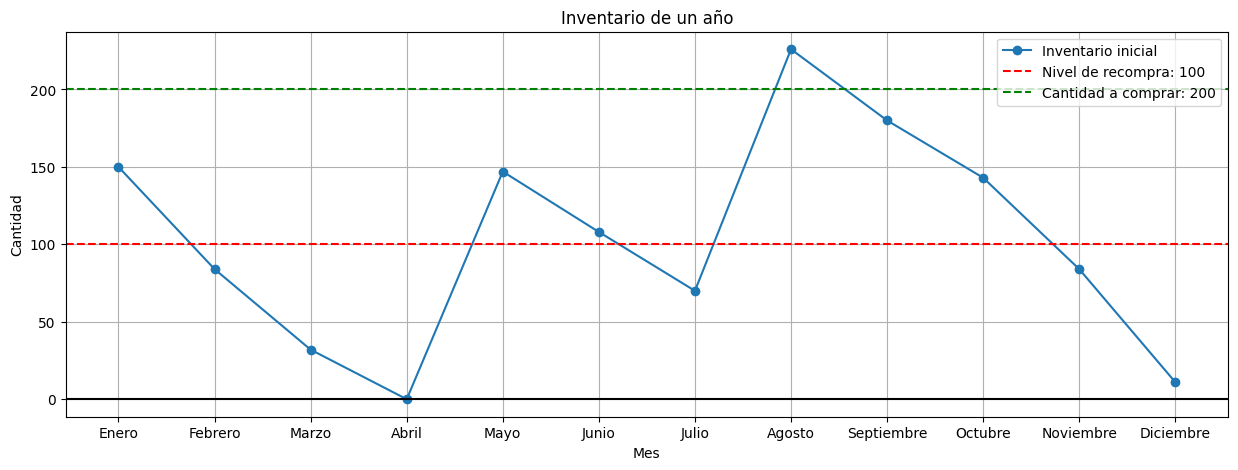

Costo por ordenar: $300.00
Costo por llevar inventario: $1,621.67
Costo por faltante: $5,600.00
Costo total: $7,521.67


In [26]:
inventario_0 = 150
recompra = 100
compra = 200

#tabla
data, costos = inventario(inventario_0, recompra, compra, 1)
print(data.to_string(index=False))

#grafica
plt.figure(figsize=(15, 5))
plt.plot(list(data["Stock Inicial"]), marker = "o", label = "Inventario inicial")
plt.axhline(y = recompra, color = "r", linestyle = "--", label = f"Nivel de recompra: {recompra}")
plt.axhline(y = compra, color = "g", linestyle = "--", label = f"Cantidad a comprar: {compra}")
plt.axhline(y = 0, color = "k")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.title("Inventario de un año")
plt.legend(loc = "best")
plt.grid(True)
plt.xticks(range(12), meses)
plt.show()

#costos
print(f"Costo por ordenar: ${costos['Costo_Pedido'].mean():,.2f}")
print(f"Costo por llevar inventario: ${costos['Costo_Almacenamiento'].mean():,.2f}")
print(f"Costo por faltante: ${costos['Costo_Faltantes'].mean():,.2f}")
print(f"Costo total: ${costos['Costo_Total'].mean():,.2f}")

# Costo total promedio anual

Simulación del inventario n veces para obtener un costo total promedio anual

In [20]:
n = 30
x = []
for i in range(1, n + 1):
  _, costos = inventario(inventario_0, recompra, compra, i)
  x.append(np.mean(costos["Costo_Total"]))

Mostramos resultados y estadísticos importantes:

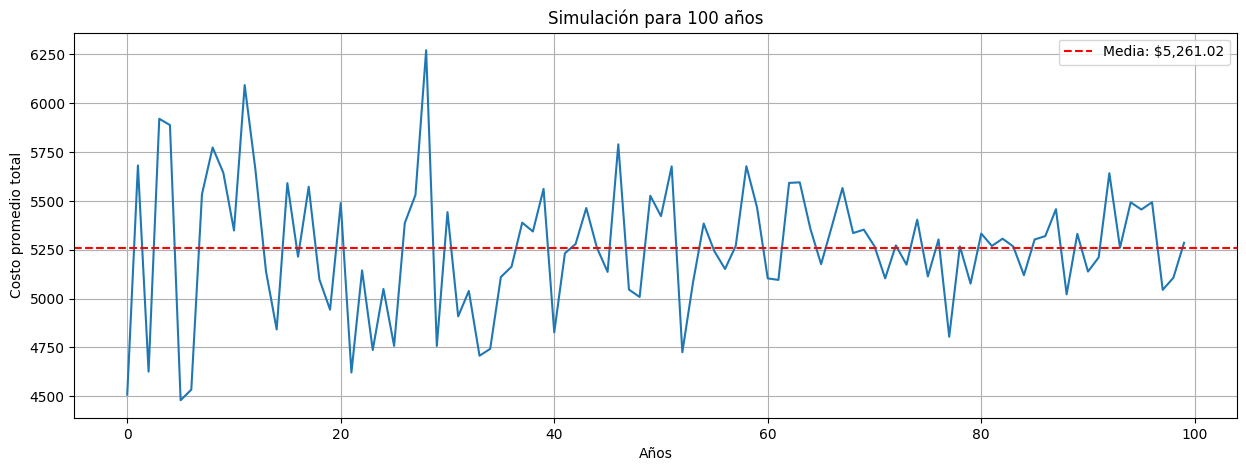

In [27]:
mu = np.mean(x)

plt.figure(figsize=(15, 5))
plt.plot(x)
plt.axhline(y = mu, color = "r", linestyle = "--", label = f"Media: ${mu:,.2f}")
plt.xlabel("Años")
plt.ylabel("Costo promedio total")
plt.title(f"Simulación para {n} años")
plt.legend(loc = "best")
plt.grid(True)
plt.show()

# Método Hooke Jeeves
Sin embargo, lo importante es obtener los valores óptimos de las variables de decisión, en este caso, las cantidades óptimas de orden y reorden. Así que para ello aplicaremos el método de Hooke Jeeves:

In [22]:
#función que simula el método (extraída de otras fuentes)
def hooke_jeeves(funcion, x0, salto=10, epsilon=1, max_iter=100):
    def explore(base, paso):
        x = base[:]
        for i in range(len(x)):
            for delta in [paso, -paso]:
                x_it = x[:]
                x_it[i] += delta
                if funcion(x_it) < funcion(x):
                    x = x_it
                    break
        return x

    x_optima = x0[:]
    for _ in range(max_iter):
        x_nueva = explore(x_optima, salto)
        if funcion(x_nueva) < funcion(x_optima):
            x_optima = [2*x_nueva[i] - x_optima[i] for i in range(len(x_optima))]
        else:
            salto /= 2
        if salto < epsilon:
            break
    return x_optima

Función objetivo:

In [23]:
#funcion objetivo de costos obtenida de nuestra función de inventario
def objetivo(x):
    R, q = int(x[0]), int(x[1])
    _, costos = inventario(150, R, q, 20)
    return costos["Costo_Total"].mean()

#ejecutamos método con función objetivo y sustituimos los valores optimos obtenidos en la función de inventario
optimos = hooke_jeeves(objetivo, [80, 150], salto=20, epsilon=5)
R_opt, q_opt = int(optimos[0]), int(optimos[1])
data, costos = inventario(150, R_opt, q_opt, 1)

Mostramos resultados:


Nivel de recompra óptimo: 120
Cantidad óptima a ordenar: 270

       Mes  Stock Inicial  Demanda  Stock Final  Faltantes  Pedidos  Inventario Promedio
     Enero            150       65           85          0        1                  117
   Febrero             85       42           43          0        0                   64
     Marzo             43       46            0          3        0                   20
     Abril              0       42            0         42        0                    0
      Mayo            225       40          185          0        0                  205
     Junio            185       31          154          0        0                  169
     Julio            154       39          115          0        1                  134
    Agosto            115       50           65          0        0                   90
Septiembre             65       35           30          0        0                   47
   Octubre             30       60            0

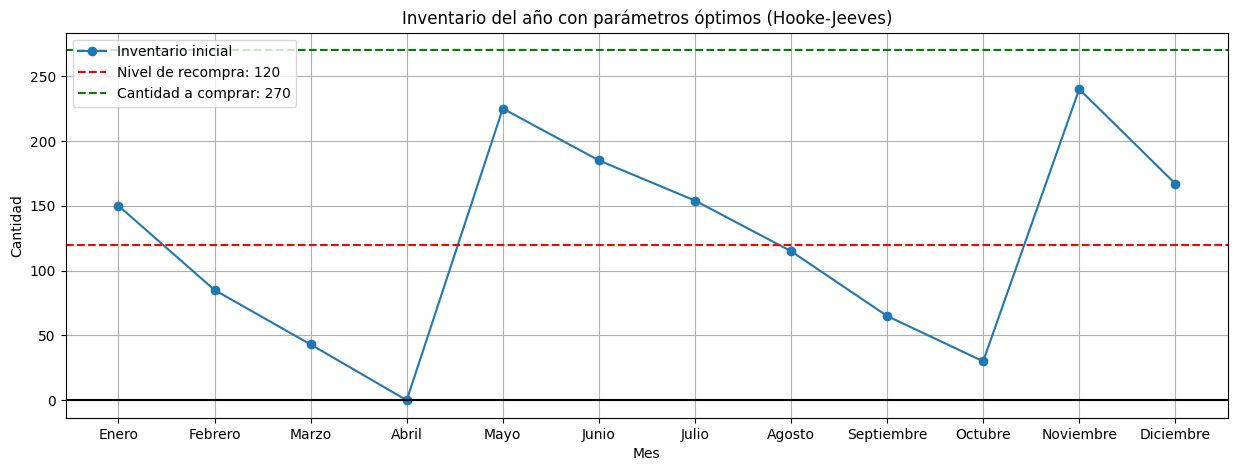

Costo por ordenar: $300.00
Costo por llevar inventario: $1,970.00
Costo por faltante: $3,750.00
Costo total: $6,020.00


In [24]:
#valores óptimos
print(f"\nNivel de recompra óptimo: {R_opt}")
print(f"Cantidad óptima a ordenar: {q_opt}\n")
print(data.to_string(index=False))

#grafica
plt.figure(figsize=(15, 5))
plt.plot(data["Stock Inicial"], marker="o", label="Inventario inicial")
plt.axhline(y=R_opt, color="r", linestyle="--", label=f"Nivel de recompra: {R_opt}")
plt.axhline(y=q_opt, color="g", linestyle="--", label=f"Cantidad a comprar: {q_opt}")
plt.axhline(y=0, color="k")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.title("Inventario del año con parámetros óptimos (Hooke-Jeeves)")
plt.legend()
plt.grid(True)
plt.xticks(range(12), meses)
plt.show()

#costos
print(f"Costo por ordenar: ${costos['Costo_Pedido'].mean():,.2f}")
print(f"Costo por llevar inventario: ${costos['Costo_Almacenamiento'].mean():,.2f}")
print(f"Costo por faltante: ${costos['Costo_Faltantes'].mean():,.2f}")
print(f"Costo total: ${costos['Costo_Total'].mean():,.2f}")